In [1]:
import sys
import os
import argparse
import json
import re
from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain.prompts.prompt import PromptTemplate
from langchain.prompts.few_shot import FewShotPromptTemplate
from langchain.prompts.example_selector.base import BaseExampleSelector
import numpy as np
import backoff  # for exponential backoff
import openai  # for OpenAI API calls
import tiktoken
import numpy as np

In [2]:
#model_name = "gpt-4"
model_name = "gpt-4-0314"
max_prompt_size = 6500
model_temp = 0.1

add_map_path = "Scenic/tests/formats/opendrive/maps/CARLA/"

In [3]:
def num_tokens_from_messages(messages, model="gpt-3.5-turbo-0301", include_final_response_prefix=True):
    """Returns the number of tokens used by a list of messages."""
    try:
        encoding = tiktoken.encoding_for_model(model)
    except KeyError:
        #print("Warning: model not found. Using cl100k_base encoding.")
        encoding = tiktoken.get_encoding("cl100k_base")
    if model == "gpt-3.5-turbo":
        #print("Warning: gpt-3.5-turbo may change over time. Returning num tokens assuming gpt-3.5-turbo-0301.")
        return num_tokens_from_messages(messages, model="gpt-3.5-turbo-0301", 
                                        include_final_response_prefix=include_final_response_prefix)
    elif model == "gpt-4":
        #print("Warning: gpt-4 may change over time. Returning num tokens assuming gpt-4-0314.")
        return num_tokens_from_messages(messages, model="gpt-4-0314", 
                                        include_final_response_prefix=include_final_response_prefix)
    elif model == "gpt-3.5-turbo-0301":
        tokens_per_message = 4  # every message follows <|start|>{role/name}\n{content}<|end|>\n
        tokens_per_name = -1  # if there's a name, the role is omitted
    elif model == "gpt-4-0314":
        tokens_per_message = 3
        tokens_per_name = 1
    else:
        raise NotImplementedError(f"""num_tokens_from_messages() is not implemented for model {model}. See https://github.com/openai/openai-python/blob/main/chatml.md for information on how messages are converted to tokens.""")
    num_tokens = 0
    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))
            if key == "name":
                num_tokens += tokens_per_name
    if include_final_response_prefix:
        num_tokens += 3  # every reply is primed with <|start|>assistant<|message|>
    return num_tokens

In [4]:
with open("../oai_key", "r") as api_key_fs:
    os.environ["OPENAI_API_KEY"] = api_key_fs.read().strip()
openai.api_key = os.getenv("OPENAI_API_KEY")

In [5]:
def example_to_chat_messages(example):
    messages = [
        {"role": "system", "name": "example_user", 
         "content": '""" Scenario description\n%s\n"""' % example['docstring']},
        {"role": "system", "name": "example_assistant", 
         "content": '```scenic\n%s\n```' % example['body']}
    ]
    return messages

def get_example_num_tokens(example):
    return num_tokens_from_messages(example_to_chat_messages(example), model_name, 
                                    include_final_response_prefix=False)

def input_to_chat_messages(example):
    docstring = example if (isinstance(example, str)) else example['docstring']
    messages = [
        {"role": "user", 
         "content": '""" Scenario description\n%s\n"""' % docstring}
    ]
    return messages

def get_input_num_tokens(example, include_final_response_prefix=True):
    return num_tokens_from_messages(input_to_chat_messages(example), model_name, 
                                    include_final_response_prefix=include_final_response_prefix)

#def escape_example_str(example_str):
#    example_str = example_str.replace("<", "<q").replace(">", "q>")
#    example_str = example_str.replace("{", "<_").replace("}", "_>")
#    return example_str
#
#def unescape_example_str(example_str):
#    example_str = example_str.replace("<_", "{").replace("_>", "}")
#    example_str = example_str.replace("<q", "<").replace("q>", ">")
#    return example_str
#
#def texualize_example_dict(example):
#    rv = dict()
#    for k, v in example.items():
#        k_str = escape_example_str(str(k))
#        v_str = escape_example_str(str(v))
#        rv[k_str] = v_str
#    return rv

In [6]:
# Edited from paragraph of Scenic documentation: https://scenic-lang.readthedocs.io/en/latest/index.html
system_message_str="""You are a helpful agent that generates specifications for car driving scenarios in the Scenic language
Scenic is a domain-specific probabilistic programming language for modeling the environments of cyber-physical systems like robots and autonomous cars. A Scenic program defines a distribution over scenes, configurations of physical objects and agents; sampling from this distribution yields concrete scenes which can be simulated to produce training or testing data. Scenic can also define (probabilistic) policies for dynamic agents, allowing modeling scenarios where agents take actions over time in response to the state of the world.

Your task is to generate Scenic scenarios, each according to its corresponding description in English included as a docstring. Write each scenario in a separate code box. Follow the examples below:"""
system_role = "system" if model_name.startswith("gpt-4") else "user"
system_message = {"role": system_role, "content": system_message_str}
system_message_len = num_tokens_from_messages([system_message], model_name, include_final_response_prefix=False)
print("System message tokens: %s" % system_message_len)

System message tokens: 152


In [7]:
def get_prompt_num_tokens(in_context_examples, input_example, system_message=system_message, extra_messages=[]):
    return (num_tokens_from_messages([system_message], model_name, include_final_response_prefix=False) + 
            sum([example["num_tokens"] for example in in_context_examples]) + 
            num_tokens_from_messages(extra_messages, model_name, include_final_response_prefix=False) + 
            get_input_num_tokens(input_example))

def get_prompt(in_context_examples, input_example, system_message=system_message, extra_messages=[]):
    rv = [system_message]
    for example in in_context_examples:
        rv.extend(example_to_chat_messages(example))
    rv.extend(input_to_chat_messages(input_example))
    rv.extend(extra_messages)
    return rv

In [8]:
print("Loading training examples...", end="", file=sys.stderr)
with open("./curated_50_50_split_augmented/simplified_augmented_dataset_a.json", "r") as in_fs:
    scenarios = json.load(in_fs)
for example in scenarios:
    example["num_tokens"] = get_example_num_tokens(example)
print(" done loading %s examples." % len(scenarios), file=sys.stderr)

scenarios_num_tokens = [example["num_tokens"] for example in scenarios]
print("Example num tokens min: %s, avg: %s, max: %s" % 
      (min(scenarios_num_tokens), np.mean(scenarios_num_tokens), max(scenarios_num_tokens)), file=sys.stderr)

Loading training examples... done loading 16 examples.
Example num tokens min: 241, avg: 512.4375, max: 702


In [9]:
print("Loading test examples...", end="", file=sys.stderr)
with open("./curated_50_50_split_augmented/simplified_augmented_dataset_b.json", "r") as in_fs:
    test_scenarios = json.load(in_fs)
#test_scenarios = [s for s in test_scenarios if s['name'].startswith('scenario')]
for example in test_scenarios:
    example["num_tokens"] = get_example_num_tokens(example)
print(" done loading %s examples." % len(test_scenarios), file=sys.stderr)

test_scenarios_num_tokens = [example["num_tokens"] for example in test_scenarios]
print("Example num tokens min: %s, avg: %s, max: %s" % 
      (min(test_scenarios_num_tokens), np.mean(test_scenarios_num_tokens), max(test_scenarios_num_tokens)), file=sys.stderr)

Loading test examples... done loading 16 examples.
Example num tokens min: 347, avg: 513.9375, max: 653


In [ ]:
def select_examples(input_example, in_context_training_set, max_tokens=max_prompt_size, max_num_examples=None,
                    system_message=system_message, extra_messages=[], example_selector='random',
                    reverse_examples=False):

    if example_selector == 'random':
        shuffled_examples = np.random.permutation(in_context_training_set)
        shuffled_examples_i = 0
        def next_random_example():
            nonlocal shuffled_examples_i
            if shuffled_examples_i < len(in_context_training_set):
                shuffled_examples_i += 1
                return shuffled_examples[shuffled_examples_i-1]
            else:
                return None
        example_selector_func = next_random_example
    else:
        example_selector_func = example_selector(input_example, in_context_training_set)
    
    init_num_tokens = get_prompt_num_tokens([], input_example, system_message=system_message, 
                                            extra_messages=extra_messages)
    num_tokens = init_num_tokens
    num_examples = 0
    rv = []
    while (num_tokens < max_tokens):
        if (max_num_examples is not None) and (num_examples >= max_num_examples):
            break
        example = example_selector_func()
        if example is None:
            break
        #example_num_tokens = get_example_num_tokens(example)
        example_num_tokens = example['num_tokens']
        if (num_tokens + example_num_tokens > max_tokens):
            break
        rv.append(example)
        num_tokens += example_num_tokens
        num_examples += 1
    if reverse_examples:
        rv.reverse()
    return rv, num_tokens

In [579]:
input_example = test_scenarios[15]
in_context_examples, num_tokens = select_examples(input_example, scenarios)
prompt = get_prompt(in_context_examples, input_example)

In [ ]:
@backoff.on_exception(backoff.expo, openai.error.RateLimitError)
def get_lm_response(prompt, model_name, model_temp):
    response = openai.ChatCompletion.create(
        model = model_name,
        temperature = model_temp,
        messages = prompt)
    return response

In [ ]:
response = get_lm_response(prompt, model_name, model_temp)

In [ ]:
input_example['docstring'], response

In [ ]:
def extract_code(response, input_example):
    generated_code_raw = response['choices'][0]['message']['content']
    generated_code_match = re.search(r'(?s)```(?:scenic)?\s?(.*)```', generated_code_raw)
    generated_code = generated_code_match.groups()[0].strip()

    docstring = input_to_chat_messages(input_example)[0]['content']
    generated_code = docstring + "\n" + generated_code

    map_dir = add_map_path + "/" if (add_map_path[-1] != "/") else add_map_path
    carla_map_match = re.search("param(?:\s+)carla_map(?:\s*)=(?:\s*)['\"](\S+)['\"]", generated_code) # CARLA map name
    if carla_map_match:
        carla_map = carla_map_match.group(1)
        map_str = "param map = localPath('%s')" % (map_dir + carla_map + ".xodr")
        generated_code = re.sub('"""\n', ('"""\n\n%s\n' % map_str), generated_code, count=1) # add after the docstring
    return generated_code, generated_code_raw

In [ ]:
generated_code, generated_code_raw = extract_code(response, input_example)

In [ ]:
def extract_code_from_example_and_simplfy(input_example):
    scenario_str = input_example['body'].strip()
    docstring = input_to_chat_messages(input_example)[0]['content']
    executable_code = docstring + "\n\n" + scenario_str
    
    scenario_str = re.sub(r'^[\s\S]*localPath[^\n]*\n', "", scenario_str, flags=re.MULTILINE)
    scenario_str = re.sub(r'^\s*#[^\n]*$', "", scenario_str, flags=re.MULTILINE) # Remove whole-line comments
    scenario_str = re.sub(r'^\s*\n', "", scenario_str, flags=re.MULTILINE) # Remove empty lines
    scenario_str = re.sub(r'^(\s*)model scenic.[\S]*', r'\1model scenic.simulators.carla.model', scenario_str, flags=re.MULTILINE) # Fix incorrect model name
    scenario_str = re.sub(r'vehicle.lincoln.mkz2017', 'vehicle.lincoln.mkz_2017', scenario_str) # Fix broken vehicle name
    scenario_str = '```scenic\n%s\n```' % scenario_str
    
    return executable_code, scenario_str

In [ ]:
#generated_code, generated_code_raw = extract_code_from_example_and_simplfy(input_example)

In [ ]:
#print(generated_code_raw)
#print(generated_code)

In [ ]:
error_user_message_template = "An error has occurred:\n{error}"

def error_to_user_chat_messages(error, previous_raw_output, previous_extra_messages=[]):
    messages = [
        {"role": "assistant",
         "content": previous_raw_output},
        {"role": "user", 
         "content": error_user_message_template.format(error=error)}
    ]
    return previous_extra_messages + messages

comment_user_message_template = "Comment:\n{comment}"

def comment_to_user_chat_messages(comment, previous_raw_output, previous_extra_messages=[]):
    messages = [
        {"role": "assistant",
         "content": previous_raw_output},
        {"role": "user", 
         "content": comment_user_message_template.format(comment=comment)}
    ]
    return previous_extra_messages + messages

In [ ]:
def update_examples(input_example, prev_examples, max_tokens=max_prompt_size, 
                    max_num_examples=None, system_message=system_message, extra_messages=[], reverse_examples=False):
    
    init_num_tokens = get_prompt_num_tokens([], input_example, system_message=system_message, 
                                            extra_messages=extra_messages)
    num_tokens = init_num_tokens
    num_examples = 0
    rv = []
    it = reversed(prev_examples) if reverse_examples else iter(prev_examples)
    for example in it:
        if (max_num_examples is not None) and (num_examples >= max_num_examples):
            break
        example_num_tokens = example['num_tokens']
        if (num_tokens + example_num_tokens > max_tokens):
            break
        rv.append(example)
        num_tokens += example_num_tokens
        num_examples += 1
    if reverse_examples:
        rv.reverse()
    return rv, num_tokens

In [580]:
extra_messages = []

In [629]:
extra_messages = error_to_user_chat_messages(scenario_error, generated_code_raw, extra_messages)

In [638]:
in_context_examples, num_tokens = update_examples(input_example, in_context_examples, extra_messages=extra_messages)
prompt = get_prompt(in_context_examples, input_example, extra_messages=extra_messages)

In [639]:
prompt

[{'role': 'system',
  'content': 'You are a helpful agent that generates specifications for car driving scenarios in the Scenic language\nScenic is a domain-specific probabilistic programming language for modeling the environments of cyber-physical systems like robots and autonomous cars. A Scenic program defines a distribution over scenes, configurations of physical objects and agents; sampling from this distribution yields concrete scenes which can be simulated to produce training or testing data. Scenic can also define (probabilistic) policies for dynamic agents, allowing modeling scenarios where agents take actions over time in response to the state of the world.\n\nYour task is to generate Scenic scenarios, each according to its corresponding description in English included as a docstring. Write each scenario in a separate code box. Follow the examples below:'},
 {'role': 'system',
  'name': 'example_user',
  'content': '""" Scenario description\nEgo vehicle makes a right turn at 

In [640]:
#generated_code, generated_code_raw = extract_code_from_example_and_simplfy(input_example)

In [641]:
response = get_lm_response(prompt, model_name, model_temp)

In [642]:
generated_code, generated_code_raw = extract_code(response, input_example)

In [643]:
#response

In [644]:
base_filename="tmp15_4_0.scenic"
base_dir="./multistep_generation/eval_b"
with open("%s/with_sim_%s" % (base_dir, base_filename), "w") as out_scenario_fs:
    out_scenario_fs.write(generated_code)

#print("Docstring: %s" % input_example["docstring"], file=sys.stderr)
print("Scenario", file=sys.stderr)
print(generated_code, file=sys.stderr)

print("\n\n=========\n\nSimulating", file=sys.stderr)
os.system(r'scenic -S %s/with_sim_%s > %s/with_sim_%s.out 2>&1' % (base_dir, base_filename, 
                                                                   base_dir, base_filename))
with open("%s/with_sim_%s.out" % (base_dir, base_filename), "r") as in_scenario_output_fs:
    scenario_output = in_scenario_output_fs.read().strip()
scenario_error_match = re.search("Traceback(?:.*)\n", scenario_output)
if scenario_error_match is None:
    print("Success!", file=sys.stderr)
    print(scenario_output, file=sys.stderr)
else:
    print("Error:", file=sys.stderr)
    scenario_error = scenario_output[scenario_error_match.span()[-1]:].strip()
    print(scenario_error, file=sys.stderr)

Scenario
""" Scenario description
Ego vehicle goes straight at an intersection and must yield when pedestrian crosses the crosswalk.
"""

param map = localPath('Scenic/tests/formats/opendrive/maps/CARLA/Town05.xodr')
param carla_map = 'Town05'
model scenic.simulators.carla.model
MODEL = 'vehicle.lincoln.mkz_2017'
EGO_INIT_DIST = [20, 25]
param EGO_SPEED = VerifaiRange(7, 10)
EGO_BRAKE = 1.0
PED_MIN_SPEED = 1.0
PED_THRESHOLD = 20
param SAFETY_DIST = VerifaiRange(10, 15)
CRASH_DIST = 5
TERM_DIST = 50
MIN_DISTANCE = 3  # Minimum distance between ego vehicle and pedestrian to avoid collision
behavior EgoBehavior(trajectory):
    flag = True
    try:
        do FollowTrajectoryBehavior(target_speed=globalParameters.EGO_SPEED, trajectory=trajectory)
    interrupt when withinDistanceToAnyObjs(self, globalParameters.SAFETY_DIST) and (ped in network.drivableRegion) and flag:
        flag = False
        while withinDistanceToAnyObjs(self, globalParameters.SAFETY_DIST + 3):
            take SetB

In [ ]:
scenario_comment = "Ego vehicle should perform the lane change, not the adversary vehicle"

In [ ]:
extra_messages = comment_to_user_chat_messages(scenario_comment, generated_code_raw, extra_messages)

In [ ]:
extra_messages

In [ ]:
scenario_comment = "Adversary vehicle must be slower than Ego vehicle"

In [ ]:
extra_messages = comment_to_user_chat_messages(scenario_comment, generated_code_raw, extra_messages)

In [ ]:
extra_messages

In [ ]:
scenario_comment = "Make both cars drive slower"
extra_messages = comment_to_user_chat_messages(scenario_comment, generated_code_raw, extra_messages)
extra_messages

In [ ]:
scenario_comment = "Do not use the 'require' statement: it causes the simulation to terminate too early since it specifies a condition to be held at all times"
extra_messages = comment_to_user_chat_messages(scenario_comment, generated_code_raw, extra_messages)
extra_messages

In [57]:
# Scenario 0 failed

In [65]:
# Scenario 1 success!

In [73]:
scenario_comment = "Create more than one adversary vehicles"
extra_messages = comment_to_user_chat_messages(scenario_comment, generated_code_raw, extra_messages)
extra_messages

[{'role': 'assistant',
  'content': "```scenic\nparam carla_map = 'Town05'\nmodel scenic.simulators.carla.model\nMODEL = 'vehicle.lincoln.mkz_2017'\nEGO_INIT_DIST = [20, 25]\nparam EGO_SPEED = VerifaiRange(7, 10)\nparam EGO_BRAKE = VerifaiRange(0.5, 1.0)\nADV_INIT_DIST = [15, 20]\nparam ADV_SPEED = VerifaiRange(7, 10)\nparam SAFETY_DIST = VerifaiRange(10, 20)\nCRASH_DIST = 5\nTERM_DIST = 70\nbehavior EgoBehavior(trajectory):\n\ttry:\n\t\tdo FollowTrajectoryBehavior(target_speed=globalParameters.EGO_SPEED, trajectory=trajectory)\n\tinterrupt when withinDistanceToAnyObjs(self, globalParameters.SAFETY_DIST):\n\t\ttake SetBrakeAction(globalParameters.EGO_BRAKE)\n\tinterrupt when withinDistanceToAnyObjs(self, CRASH_DIST):\n\t\tterminate\nintersection = Uniform(*filter(lambda i: not i.isSignalized, network.intersections))\negoInitLane = Uniform(*intersection.incomingLanes)\negoManeuver = Uniform(*filter(lambda m: m.type is ManeuverType.STRAIGHT, egoInitLane.maneuvers))\negoTrajectory = [egoI

In [91]:
scenario_comment = "Do not use multiple values for EGO_INIT_DIST and ADV_INIT_DIST"
extra_messages = comment_to_user_chat_messages(scenario_comment, generated_code_raw, extra_messages)
extra_messages

[{'role': 'assistant',
  'content': "```scenic\nparam carla_map = 'Town05'\nmodel scenic.simulators.carla.model\nMODEL = 'vehicle.lincoln.mkz_2017'\nEGO_INIT_DIST = [20, 25]\nparam EGO_SPEED = VerifaiRange(7, 10)\nparam EGO_BRAKE = VerifaiRange(0.5, 1.0)\nADV_INIT_DIST = [15, 20]\nparam ADV_SPEED = VerifaiRange(7, 10)\nparam SAFETY_DIST = VerifaiRange(10, 20)\nCRASH_DIST = 5\nTERM_DIST = 70\nbehavior EgoBehavior(trajectory):\n\ttry:\n\t\tdo FollowTrajectoryBehavior(target_speed=globalParameters.EGO_SPEED, trajectory=trajectory)\n\tinterrupt when withinDistanceToAnyObjs(self, globalParameters.SAFETY_DIST):\n\t\ttake SetBrakeAction(globalParameters.EGO_BRAKE)\n\tinterrupt when withinDistanceToAnyObjs(self, CRASH_DIST):\n\t\tterminate\nintersection = Uniform(*filter(lambda i: not i.isSignalized, network.intersections))\negoInitLane = Uniform(*intersection.incomingLanes)\negoManeuver = Uniform(*filter(lambda m: m.type is ManeuverType.STRAIGHT, egoInitLane.maneuvers))\negoTrajectory = [egoI

In [103]:
scenario_comment = "Do not use a for loop to define the adversary vehicles, define them without any loop and make sure to assign them different names"
extra_messages = comment_to_user_chat_messages(scenario_comment, generated_code_raw, extra_messages)
extra_messages

[{'role': 'assistant',
  'content': "```scenic\nparam carla_map = 'Town05'\nmodel scenic.simulators.carla.model\nMODEL = 'vehicle.lincoln.mkz_2017'\nEGO_INIT_DIST = [20, 25]\nparam EGO_SPEED = VerifaiRange(7, 10)\nparam EGO_BRAKE = VerifaiRange(0.5, 1.0)\nADV_INIT_DIST = [15, 20]\nparam ADV_SPEED = VerifaiRange(7, 10)\nparam SAFETY_DIST = VerifaiRange(10, 20)\nCRASH_DIST = 5\nTERM_DIST = 70\nbehavior EgoBehavior(trajectory):\n\ttry:\n\t\tdo FollowTrajectoryBehavior(target_speed=globalParameters.EGO_SPEED, trajectory=trajectory)\n\tinterrupt when withinDistanceToAnyObjs(self, globalParameters.SAFETY_DIST):\n\t\ttake SetBrakeAction(globalParameters.EGO_BRAKE)\n\tinterrupt when withinDistanceToAnyObjs(self, CRASH_DIST):\n\t\tterminate\nintersection = Uniform(*filter(lambda i: not i.isSignalized, network.intersections))\negoInitLane = Uniform(*intersection.incomingLanes)\negoManeuver = Uniform(*filter(lambda m: m.type is ManeuverType.STRAIGHT, egoInitLane.maneuvers))\negoTrajectory = [egoI

In [111]:
scenario_comment = "Actually, allow a range for EGO_INIT_DIST"
extra_messages = comment_to_user_chat_messages(scenario_comment, generated_code_raw, extra_messages)
extra_messages

[{'role': 'assistant',
  'content': "```scenic\nparam carla_map = 'Town05'\nmodel scenic.simulators.carla.model\nMODEL = 'vehicle.lincoln.mkz_2017'\nEGO_INIT_DIST = [20, 25]\nparam EGO_SPEED = VerifaiRange(7, 10)\nparam EGO_BRAKE = VerifaiRange(0.5, 1.0)\nADV_INIT_DIST = [15, 20]\nparam ADV_SPEED = VerifaiRange(7, 10)\nparam SAFETY_DIST = VerifaiRange(10, 20)\nCRASH_DIST = 5\nTERM_DIST = 70\nbehavior EgoBehavior(trajectory):\n\ttry:\n\t\tdo FollowTrajectoryBehavior(target_speed=globalParameters.EGO_SPEED, trajectory=trajectory)\n\tinterrupt when withinDistanceToAnyObjs(self, globalParameters.SAFETY_DIST):\n\t\ttake SetBrakeAction(globalParameters.EGO_BRAKE)\n\tinterrupt when withinDistanceToAnyObjs(self, CRASH_DIST):\n\t\tterminate\nintersection = Uniform(*filter(lambda i: not i.isSignalized, network.intersections))\negoInitLane = Uniform(*intersection.incomingLanes)\negoManeuver = Uniform(*filter(lambda m: m.type is ManeuverType.STRAIGHT, egoInitLane.maneuvers))\negoTrajectory = [egoI

In [2]:
# Scenario 2 partial success 
# (succeded initially but it failed when asked to generate more than one adversarial vehichle)

In [134]:
# Scenario 3 success!

In [165]:
# Scenario 4 success!

In [181]:
scenario_comment = "Make sure that the blocking obstacle is in the lane where the ego vehicle starts and that the oncoming vehicle starts close"
extra_messages = comment_to_user_chat_messages(scenario_comment, generated_code_raw, extra_messages)
extra_messages

[{'role': 'assistant',
  'content': '```scenic\nparam carla_map = \'Town05\'\nmodel scenic.simulators.carla.model\nEGO_MODEL = "vehicle.lincoln.mkz_2017"\nEGO_SPEED = 10\nSAFETY_DISTANCE = 10\nBRAKE_INTENSITY = 1.0\nBLOCKING_DISTANCE = 20\nONCOMING_DISTANCE = 50\nbehavior EgoBehavior():\n    try:\n        do FollowLaneBehavior(target_speed=EGO_SPEED)\n    interrupt when withinDistanceToObjsInLane(self, SAFETY_DISTANCE):\n        take SetBrakeAction(BRAKE_INTENSITY)\n        newLaneSec = self.laneSection.laneToLeft\n        do LaneChangeBehavior(laneSectionToSwitch=newLaneSec, target_speed=EGO_SPEED)\n        do FollowLaneBehavior(target_speed=EGO_SPEED)\n        do LaneChangeBehavior(laneSectionToSwitch=self.laneSection.laneToRight, target_speed=EGO_SPEED)\nlane = Uniform(*network.lanes)\nspot = OrientedPoint on lane.centerline\nblocking_spot = OrientedPoint following roadDirection from spot for BLOCKING_DISTANCE\noncoming_spot = OrientedPoint following roadDirection from spot for -ONC

In [191]:
scenario_comment = "Make both cars drive slower and make sure that the adversary car travels in the opposite direction"
extra_messages = comment_to_user_chat_messages(scenario_comment, generated_code_raw, extra_messages)
extra_messages

[{'role': 'assistant',
  'content': '```scenic\nparam carla_map = \'Town05\'\nmodel scenic.simulators.carla.model\nEGO_MODEL = "vehicle.lincoln.mkz_2017"\nEGO_SPEED = 10\nSAFETY_DISTANCE = 10\nBRAKE_INTENSITY = 1.0\nBLOCKING_DISTANCE = 20\nONCOMING_DISTANCE = 50\nbehavior EgoBehavior():\n    try:\n        do FollowLaneBehavior(target_speed=EGO_SPEED)\n    interrupt when withinDistanceToObjsInLane(self, SAFETY_DISTANCE):\n        take SetBrakeAction(BRAKE_INTENSITY)\n        newLaneSec = self.laneSection.laneToLeft\n        do LaneChangeBehavior(laneSectionToSwitch=newLaneSec, target_speed=EGO_SPEED)\n        do FollowLaneBehavior(target_speed=EGO_SPEED)\n        do LaneChangeBehavior(laneSectionToSwitch=self.laneSection.laneToRight, target_speed=EGO_SPEED)\nlane = Uniform(*network.lanes)\nspot = OrientedPoint on lane.centerline\nblocking_spot = OrientedPoint following roadDirection from spot for BLOCKING_DISTANCE\noncoming_spot = OrientedPoint following roadDirection from spot for -ONC

In [198]:
scenario_comment = "When selecting the lanes, make sure that the ego vehicle lane has a lane to the left in the opposite direction where you should place the oncoming car"
extra_messages = comment_to_user_chat_messages(scenario_comment, generated_code_raw, extra_messages)
extra_messages

[{'role': 'assistant',
  'content': '```scenic\nparam carla_map = \'Town05\'\nmodel scenic.simulators.carla.model\nEGO_MODEL = "vehicle.lincoln.mkz_2017"\nEGO_SPEED = 10\nSAFETY_DISTANCE = 10\nBRAKE_INTENSITY = 1.0\nBLOCKING_DISTANCE = 20\nONCOMING_DISTANCE = 50\nbehavior EgoBehavior():\n    try:\n        do FollowLaneBehavior(target_speed=EGO_SPEED)\n    interrupt when withinDistanceToObjsInLane(self, SAFETY_DISTANCE):\n        take SetBrakeAction(BRAKE_INTENSITY)\n        newLaneSec = self.laneSection.laneToLeft\n        do LaneChangeBehavior(laneSectionToSwitch=newLaneSec, target_speed=EGO_SPEED)\n        do FollowLaneBehavior(target_speed=EGO_SPEED)\n        do LaneChangeBehavior(laneSectionToSwitch=self.laneSection.laneToRight, target_speed=EGO_SPEED)\nlane = Uniform(*network.lanes)\nspot = OrientedPoint on lane.centerline\nblocking_spot = OrientedPoint following roadDirection from spot for BLOCKING_DISTANCE\noncoming_spot = OrientedPoint following roadDirection from spot for -ONC

In [216]:
# Scenario 5 failed

In [244]:
scenario_comment = "Make the initial requirements less stringent"
extra_messages = comment_to_user_chat_messages(scenario_comment, generated_code_raw, extra_messages)
extra_messages

[{'role': 'assistant',
  'content': "```scenic\nparam carla_map = 'Town05'\nmodel scenic.simulators.carla.model\nMODEL = 'vehicle.lincoln.mkz_2017'\nEGO_INIT_DIST = [20, 40]\nparam EGO_SPEED = VerifaiRange(7, 10)\nparam EGO_BRAKE = VerifaiRange(0.5, 1.0)\nONCOMING_INIT_DIST = [20, 40]\nparam ONCOMING_SPEED = VerifaiRange(7, 10)\nparam SAFETY_DIST = VerifaiRange(10, 20)\nCRASH_DIST = 5\nTERM_DIST = 70\nbehavior EgoBehavior(trajectory):\n\tflag = True\n\ttry:\n\t\tdo FollowTrajectoryBehavior(target_speed=globalParameters.EGO_SPEED, trajectory=trajectory)\n\tinterrupt when withinDistanceToAnyObjs(self, globalParameters.SAFETY_DIST) and flag:\n\t\tflag = False\n\t\twhile withinDistanceToAnyObjs(self, globalParameters.SAFETY_DIST + 3):\n\t\t\ttake SetBrakeAction(EGO_BRAKE)\n\tinterrupt when withinDistanceToAnyObjs(self, CRASH_DIST):\n\t\tterminate\nintersection = Uniform(*filter(lambda i: i.is4Way, network.intersections))\negoInitLane = Uniform(*intersection.incomingLanes)\negoManeuver = Un

In [250]:
# Scenario 6 failed (Scenic failed to generate valid scenario, unhelpful error message)

In [272]:
# Scenario 7 failed (Scenic failed to generate valid scenario, unhelpful error message)

In [280]:
# Scenario 8 success!

In [288]:
scenario_comment = "Use a higher safety distance"
extra_messages = comment_to_user_chat_messages(scenario_comment, generated_code_raw, extra_messages)
extra_messages

[{'role': 'assistant',
  'content': "```scenic\nparam carla_map = 'Town05'\nmodel scenic.simulators.carla.model\nMODEL = 'vehicle.lincoln.mkz_2017'\nEGO_INIT_DIST = [20, 25]\nparam EGO_SPEED = VerifaiRange(7, 10)\nparam EGO_BRAKE = VerifaiRange(0.5, 1.0)\nADV_INIT_DIST = [10, 15]\nparam ADV_SPEED = VerifaiRange(7, 10)\nparam SAFETY_DIST = VerifaiRange(10, 20)\nCRASH_DIST = 5\nTERM_DIST = 70\nbehavior EgoBehavior(trajectory):\n\ttry:\n\t\tdo FollowTrajectoryBehavior(target_speed=globalParameters.EGO_SPEED, trajectory=trajectory)\n\tinterrupt when withinDistanceToAnyObjs(self, globalParameters.SAFETY_DIST):\n\t\ttake SetBrakeAction(globalParameters.EGO_BRAKE)\n\tinterrupt when withinDistanceToAnyObjs(self, CRASH_DIST):\n\t\tterminate\nintersection = Uniform(*filter(lambda i: i.is4Way, network.intersections))\negoInitLane = Uniform(*intersection.incomingLanes)\negoManeuver = Uniform(*filter(lambda m: m.type is ManeuverType.RIGHT_TURN, egoInitLane.maneuvers))\negoTrajectory = [egoInitLane,

In [295]:
# Scenario 9 success!

In [306]:
scenario_comment = "Use a wider range for EGO_INIT_DIST and ADV_INIT_DIST"
extra_messages = comment_to_user_chat_messages(scenario_comment, generated_code_raw, extra_messages)
extra_messages

[{'role': 'assistant',
  'content': "```scenic\nparam carla_map = 'Town05'\nmodel scenic.simulators.carla.model\nMODEL = 'vehicle.lincoln.mkz_2017'\nEGO_INIT_DIST = [20, 25]\nparam EGO_SPEED = VerifaiRange(7, 10)\nparam EGO_BRAKE = VerifaiRange(0.5, 1.0)\nADV_INIT_DIST = [15, 20]\nparam ADV_SPEED = VerifaiRange(7, 10)\nparam SAFETY_DIST = VerifaiRange(10, 20)\nCRASH_DIST = 5\nTERM_DIST = 70\nbehavior EgoBehavior(trajectory):\n\ttry:\n\t\tdo FollowTrajectoryBehavior(target_speed=globalParameters.EGO_SPEED, trajectory=trajectory)\n\tinterrupt when withinDistanceToAnyObjs(self, globalParameters.SAFETY_DIST):\n\t\ttake SetBrakeAction(globalParameters.EGO_BRAKE)\n\tinterrupt when withinDistanceToAnyObjs(self, CRASH_DIST):\n\t\tterminate\nintersection = Uniform(*filter(lambda i: i.is3Way, network.intersections))\negoInitLane = Uniform(*intersection.incomingLanes)\negoManeuver = Uniform(*filter(lambda m: m.type is ManeuverType.STRAIGHT, egoInitLane.maneuvers))\negoTrajectory = [egoInitLane, e

In [314]:
# Scenario 10 success!

In [349]:
scenario_comment = "Place the adversary vehicle on a the left lane"
extra_messages = comment_to_user_chat_messages(scenario_comment, generated_code_raw, extra_messages)
extra_messages

[{'role': 'assistant',
  'content': "```scenic\nparam carla_map = 'Town05'\nmodel scenic.simulators.carla.model\nMODEL = 'vehicle.lincoln.mkz_2017'\nEGO_INIT_DIST = [20, 25]\nparam EGO_SPEED = VerifaiRange(7, 10)\nEGO_BRAKE = 1.0\nADV_INIT_DIST = [15, 20]\nparam ADV_SPEED = VerifaiRange(7, 10)\nparam SAFETY_DIST = VerifaiRange(10, 20)\nCRASH_DIST = 5\nTERM_DIST = 70\nbehavior EgoBehavior():\n\ttry:\n\t\tdo FollowLaneBehavior(target_speed=globalParameters.EGO_SPEED)\n\tinterrupt when withinDistanceToAnyObjs(self, globalParameters.SAFETY_DIST):\n\t\ttake SetBrakeAction(EGO_BRAKE)\n\tinterrupt when (distance to adversary) > ADV_INIT_DIST[1]:\n\t\tfasterLaneSec = self.laneSection.fasterLane\n\t\tdo LaneChangeBehavior(\n\t\t\t\tlaneSectionToSwitch=fasterLaneSec,\n\t\t\t\ttarget_speed=globalParameters.EGO_SPEED)\n\t\tdo FollowLaneBehavior(target_speed=globalParameters.EGO_SPEED) for TERM_DIST\n\t\tterminate\n\tinterrupt when withinDistanceToAnyObjs(self, CRASH_DIST):\n\t\tterminate\nintersec

In [357]:
scenario_comment = "Make the adversary vehicle go straight without performing any lane changes"
extra_messages = comment_to_user_chat_messages(scenario_comment, generated_code_raw, extra_messages)
extra_messages

[{'role': 'assistant',
  'content': "```scenic\nparam carla_map = 'Town05'\nmodel scenic.simulators.carla.model\nMODEL = 'vehicle.lincoln.mkz_2017'\nEGO_INIT_DIST = [20, 25]\nparam EGO_SPEED = VerifaiRange(7, 10)\nEGO_BRAKE = 1.0\nADV_INIT_DIST = [15, 20]\nparam ADV_SPEED = VerifaiRange(7, 10)\nparam SAFETY_DIST = VerifaiRange(10, 20)\nCRASH_DIST = 5\nTERM_DIST = 70\nbehavior EgoBehavior():\n\ttry:\n\t\tdo FollowLaneBehavior(target_speed=globalParameters.EGO_SPEED)\n\tinterrupt when withinDistanceToAnyObjs(self, globalParameters.SAFETY_DIST):\n\t\ttake SetBrakeAction(EGO_BRAKE)\n\tinterrupt when (distance to adversary) > ADV_INIT_DIST[1]:\n\t\tfasterLaneSec = self.laneSection.fasterLane\n\t\tdo LaneChangeBehavior(\n\t\t\t\tlaneSectionToSwitch=fasterLaneSec,\n\t\t\t\ttarget_speed=globalParameters.EGO_SPEED)\n\t\tdo FollowLaneBehavior(target_speed=globalParameters.EGO_SPEED) for TERM_DIST\n\t\tterminate\n\tinterrupt when withinDistanceToAnyObjs(self, CRASH_DIST):\n\t\tterminate\nintersec

In [365]:
scenario_comment = "In the generated code, the adversary vehicle is attempting a lane change to the right. This is incorrrect, make it stay on the left lane"
extra_messages = comment_to_user_chat_messages(scenario_comment, generated_code_raw, extra_messages)
extra_messages

[{'role': 'assistant',
  'content': "```scenic\nparam carla_map = 'Town05'\nmodel scenic.simulators.carla.model\nMODEL = 'vehicle.lincoln.mkz_2017'\nEGO_INIT_DIST = [20, 25]\nparam EGO_SPEED = VerifaiRange(7, 10)\nEGO_BRAKE = 1.0\nADV_INIT_DIST = [15, 20]\nparam ADV_SPEED = VerifaiRange(7, 10)\nparam SAFETY_DIST = VerifaiRange(10, 20)\nCRASH_DIST = 5\nTERM_DIST = 70\nbehavior EgoBehavior():\n\ttry:\n\t\tdo FollowLaneBehavior(target_speed=globalParameters.EGO_SPEED)\n\tinterrupt when withinDistanceToAnyObjs(self, globalParameters.SAFETY_DIST):\n\t\ttake SetBrakeAction(EGO_BRAKE)\n\tinterrupt when (distance to adversary) > ADV_INIT_DIST[1]:\n\t\tfasterLaneSec = self.laneSection.fasterLane\n\t\tdo LaneChangeBehavior(\n\t\t\t\tlaneSectionToSwitch=fasterLaneSec,\n\t\t\t\ttarget_speed=globalParameters.EGO_SPEED)\n\t\tdo FollowLaneBehavior(target_speed=globalParameters.EGO_SPEED) for TERM_DIST\n\t\tterminate\n\tinterrupt when withinDistanceToAnyObjs(self, CRASH_DIST):\n\t\tterminate\nintersec

In [376]:
scenario_comment = "Make sure that the ego vehicle and the stationary vehicle start on the right lane. Increase the termination distance."
extra_messages = comment_to_user_chat_messages(scenario_comment, generated_code_raw, extra_messages)
extra_messages

[{'role': 'assistant',
  'content': "```scenic\nparam carla_map = 'Town05'\nmodel scenic.simulators.carla.model\nMODEL = 'vehicle.lincoln.mkz_2017'\nEGO_INIT_DIST = [20, 25]\nparam EGO_SPEED = VerifaiRange(7, 10)\nEGO_BRAKE = 1.0\nADV_INIT_DIST = [15, 20]\nparam ADV_SPEED = VerifaiRange(7, 10)\nparam SAFETY_DIST = VerifaiRange(10, 20)\nCRASH_DIST = 5\nTERM_DIST = 70\nbehavior EgoBehavior():\n\ttry:\n\t\tdo FollowLaneBehavior(target_speed=globalParameters.EGO_SPEED)\n\tinterrupt when withinDistanceToAnyObjs(self, globalParameters.SAFETY_DIST):\n\t\ttake SetBrakeAction(EGO_BRAKE)\n\tinterrupt when (distance to adversary) > ADV_INIT_DIST[1]:\n\t\tfasterLaneSec = self.laneSection.fasterLane\n\t\tdo LaneChangeBehavior(\n\t\t\t\tlaneSectionToSwitch=fasterLaneSec,\n\t\t\t\ttarget_speed=globalParameters.EGO_SPEED)\n\t\tdo FollowLaneBehavior(target_speed=globalParameters.EGO_SPEED) for TERM_DIST\n\t\tterminate\n\tinterrupt when withinDistanceToAnyObjs(self, CRASH_DIST):\n\t\tterminate\nintersec

In [411]:
# Scenario 11 failed

In [429]:
scenario_comment = "Make sure that the badly parked car is stationary and not oriented parallel to the road"
extra_messages = comment_to_user_chat_messages(scenario_comment, generated_code_raw, extra_messages)
extra_messages

[{'role': 'assistant',
  'content': "```scenic\nparam carla_map = 'Town01'\nmodel scenic.simulators.carla.model\nMODEL = 'vehicle.lincoln.mkz_2017'\nEGO_INIT_DIST = [-20, -15]\nparam EGO_SPEED = VerifaiRange(7, 10)\nEGO_BRAKE = 1.0\nBADLY_PARKED_DIST = [-5, 0]\nparam BADLY_PARKED_SPEED = VerifaiRange(3, 5)\nparam SAFETY_DIST = VerifaiRange(10, 15)\nCRASH_DIST = 5\nTERM_DIST = 50\nbehavior EgoBehavior():\n    try:\n        do FollowLaneBehavior(target_speed=globalParameters.EGO_SPEED)\n    interrupt when withinDistanceToAnyObjs(self, globalParameters.SAFETY_DIST):\n        take SetBrakeAction(EGO_BRAKE)\n    interrupt when withinDistanceToAnyObjs(self, CRASH_DIST):\n        terminate\nbehavior BadlyParkedBehavior():\n    do FollowLaneBehavior(target_speed=globalParameters.BADLY_PARKED_SPEED)\nlane = Uniform(*network.lanes)\nstart = OrientedPoint on lane.centerline\nego = Car following roadDirection from start for EGO_INIT_DIST,\n    with blueprint MODEL,\n    with behavior EgoBehavior()

In [439]:
scenario_comment = "Make sure that the badly parked car is stationary and oriented close to parallel but not exactly parallel to the road. Make the ego car start further behind"
extra_messages = comment_to_user_chat_messages(scenario_comment, generated_code_raw, extra_messages)
extra_messages

[{'role': 'assistant',
  'content': "```scenic\nparam carla_map = 'Town01'\nmodel scenic.simulators.carla.model\nMODEL = 'vehicle.lincoln.mkz_2017'\nEGO_INIT_DIST = [-20, -15]\nparam EGO_SPEED = VerifaiRange(7, 10)\nEGO_BRAKE = 1.0\nBADLY_PARKED_DIST = [-5, 0]\nparam BADLY_PARKED_SPEED = VerifaiRange(3, 5)\nparam SAFETY_DIST = VerifaiRange(10, 15)\nCRASH_DIST = 5\nTERM_DIST = 50\nbehavior EgoBehavior():\n    try:\n        do FollowLaneBehavior(target_speed=globalParameters.EGO_SPEED)\n    interrupt when withinDistanceToAnyObjs(self, globalParameters.SAFETY_DIST):\n        take SetBrakeAction(EGO_BRAKE)\n    interrupt when withinDistanceToAnyObjs(self, CRASH_DIST):\n        terminate\nbehavior BadlyParkedBehavior():\n    do FollowLaneBehavior(target_speed=globalParameters.BADLY_PARKED_SPEED)\nlane = Uniform(*network.lanes)\nstart = OrientedPoint on lane.centerline\nego = Car following roadDirection from start for EGO_INIT_DIST,\n    with blueprint MODEL,\n    with behavior EgoBehavior()

In [449]:
scenario_comment = "Make the ego car avoid the badly parked car by performing a lane change"
extra_messages = comment_to_user_chat_messages(scenario_comment, generated_code_raw, extra_messages)
extra_messages

[{'role': 'assistant',
  'content': "```scenic\nparam carla_map = 'Town01'\nmodel scenic.simulators.carla.model\nMODEL = 'vehicle.lincoln.mkz_2017'\nEGO_INIT_DIST = [-20, -15]\nparam EGO_SPEED = VerifaiRange(7, 10)\nEGO_BRAKE = 1.0\nBADLY_PARKED_DIST = [-5, 0]\nparam BADLY_PARKED_SPEED = VerifaiRange(3, 5)\nparam SAFETY_DIST = VerifaiRange(10, 15)\nCRASH_DIST = 5\nTERM_DIST = 50\nbehavior EgoBehavior():\n    try:\n        do FollowLaneBehavior(target_speed=globalParameters.EGO_SPEED)\n    interrupt when withinDistanceToAnyObjs(self, globalParameters.SAFETY_DIST):\n        take SetBrakeAction(EGO_BRAKE)\n    interrupt when withinDistanceToAnyObjs(self, CRASH_DIST):\n        terminate\nbehavior BadlyParkedBehavior():\n    do FollowLaneBehavior(target_speed=globalParameters.BADLY_PARKED_SPEED)\nlane = Uniform(*network.lanes)\nstart = OrientedPoint on lane.centerline\nego = Car following roadDirection from start for EGO_INIT_DIST,\n    with blueprint MODEL,\n    with behavior EgoBehavior()

In [459]:
scenario_comment = "Increase the initial distance range"
extra_messages = comment_to_user_chat_messages(scenario_comment, generated_code_raw, extra_messages)
extra_messages

[{'role': 'assistant',
  'content': "```scenic\nparam carla_map = 'Town01'\nmodel scenic.simulators.carla.model\nMODEL = 'vehicle.lincoln.mkz_2017'\nEGO_INIT_DIST = [-20, -15]\nparam EGO_SPEED = VerifaiRange(7, 10)\nEGO_BRAKE = 1.0\nBADLY_PARKED_DIST = [-5, 0]\nparam BADLY_PARKED_SPEED = VerifaiRange(3, 5)\nparam SAFETY_DIST = VerifaiRange(10, 15)\nCRASH_DIST = 5\nTERM_DIST = 50\nbehavior EgoBehavior():\n    try:\n        do FollowLaneBehavior(target_speed=globalParameters.EGO_SPEED)\n    interrupt when withinDistanceToAnyObjs(self, globalParameters.SAFETY_DIST):\n        take SetBrakeAction(EGO_BRAKE)\n    interrupt when withinDistanceToAnyObjs(self, CRASH_DIST):\n        terminate\nbehavior BadlyParkedBehavior():\n    do FollowLaneBehavior(target_speed=globalParameters.BADLY_PARKED_SPEED)\nlane = Uniform(*network.lanes)\nstart = OrientedPoint on lane.centerline\nego = Car following roadDirection from start for EGO_INIT_DIST,\n    with blueprint MODEL,\n    with behavior EgoBehavior()

In [470]:
# Scenario 12 failed

In [479]:
# Scenario 13 success!

In [488]:
scenario_comment = "Make sure the pedastrian crosses in front of the ego car"
extra_messages = comment_to_user_chat_messages(scenario_comment, generated_code_raw, extra_messages)
extra_messages

[{'role': 'assistant',
  'content': "```scenic\nparam carla_map = 'Town05'\nmodel scenic.simulators.carla.model\nMODEL = 'vehicle.lincoln.mkz_2017'\nEGO_INIT_DIST = [20, 25]\nparam EGO_SPEED = VerifaiRange(7, 10)\nEGO_BRAKE = 1.0\nPED_MIN_SPEED = 1.0\nPED_THRESHOLD = 20\nparam SAFETY_DIST = VerifaiRange(10, 15)\nCRASH_DIST = 5\nTERM_DIST = 50\nbehavior EgoBehavior(trajectory):\n    flag = True\n    try:\n        do FollowTrajectoryBehavior(target_speed=globalParameters.EGO_SPEED, trajectory=trajectory)\n    interrupt when withinDistanceToAnyObjs(self, globalParameters.SAFETY_DIST) and (ped in network.drivableRegion) and flag:\n        flag = False\n        while withinDistanceToAnyObjs(self, globalParameters.SAFETY_DIST + 3):\n            take SetBrakeAction(EGO_BRAKE)\n    interrupt when withinDistanceToAnyObjs(self, CRASH_DIST):\n        terminate\nintersection = Uniform(*filter(lambda i: i.is4Way or i.is3Way, network.intersections))\negoManeuver = Uniform(*filter(lambda m: m.type is

In [496]:
scenario_comment = "After braking, the ego car should wait for the pedastrian to clear the intersection before starting to move again"
extra_messages = comment_to_user_chat_messages(scenario_comment, generated_code_raw, extra_messages)
extra_messages

[{'role': 'assistant',
  'content': "```scenic\nparam carla_map = 'Town05'\nmodel scenic.simulators.carla.model\nMODEL = 'vehicle.lincoln.mkz_2017'\nEGO_INIT_DIST = [20, 25]\nparam EGO_SPEED = VerifaiRange(7, 10)\nEGO_BRAKE = 1.0\nPED_MIN_SPEED = 1.0\nPED_THRESHOLD = 20\nparam SAFETY_DIST = VerifaiRange(10, 15)\nCRASH_DIST = 5\nTERM_DIST = 50\nbehavior EgoBehavior(trajectory):\n    flag = True\n    try:\n        do FollowTrajectoryBehavior(target_speed=globalParameters.EGO_SPEED, trajectory=trajectory)\n    interrupt when withinDistanceToAnyObjs(self, globalParameters.SAFETY_DIST) and (ped in network.drivableRegion) and flag:\n        flag = False\n        while withinDistanceToAnyObjs(self, globalParameters.SAFETY_DIST + 3):\n            take SetBrakeAction(EGO_BRAKE)\n    interrupt when withinDistanceToAnyObjs(self, CRASH_DIST):\n        terminate\nintersection = Uniform(*filter(lambda i: i.is4Way or i.is3Way, network.intersections))\negoManeuver = Uniform(*filter(lambda m: m.type is

In [513]:
scenario_comment = "Make sure that the pedastrian starts crossing from a sidewalk and ends crossing at a sidewalk"
extra_messages = comment_to_user_chat_messages(scenario_comment, generated_code_raw, extra_messages)
extra_messages

[{'role': 'assistant',
  'content': "```scenic\nparam carla_map = 'Town05'\nmodel scenic.simulators.carla.model\nMODEL = 'vehicle.lincoln.mkz_2017'\nEGO_INIT_DIST = [20, 25]\nparam EGO_SPEED = VerifaiRange(7, 10)\nEGO_BRAKE = 1.0\nPED_MIN_SPEED = 1.0\nPED_THRESHOLD = 20\nparam SAFETY_DIST = VerifaiRange(10, 15)\nCRASH_DIST = 5\nTERM_DIST = 50\nbehavior EgoBehavior(trajectory):\n    flag = True\n    try:\n        do FollowTrajectoryBehavior(target_speed=globalParameters.EGO_SPEED, trajectory=trajectory)\n    interrupt when withinDistanceToAnyObjs(self, globalParameters.SAFETY_DIST) and (ped in network.drivableRegion) and flag:\n        flag = False\n        while withinDistanceToAnyObjs(self, globalParameters.SAFETY_DIST + 3):\n            take SetBrakeAction(EGO_BRAKE)\n    interrupt when withinDistanceToAnyObjs(self, CRASH_DIST):\n        terminate\nintersection = Uniform(*filter(lambda i: i.is4Way or i.is3Way, network.intersections))\negoManeuver = Uniform(*filter(lambda m: m.type is

In [538]:
scenario_comment = "Specify the pedastrian position as an offset from the lane"
extra_messages = comment_to_user_chat_messages(scenario_comment, generated_code_raw, extra_messages)
extra_messages

[{'role': 'assistant',
  'content': "```scenic\nparam carla_map = 'Town05'\nmodel scenic.simulators.carla.model\nMODEL = 'vehicle.lincoln.mkz_2017'\nEGO_INIT_DIST = [20, 25]\nparam EGO_SPEED = VerifaiRange(7, 10)\nEGO_BRAKE = 1.0\nPED_MIN_SPEED = 1.0\nPED_THRESHOLD = 20\nparam SAFETY_DIST = VerifaiRange(10, 15)\nCRASH_DIST = 5\nTERM_DIST = 50\nbehavior EgoBehavior(trajectory):\n    flag = True\n    try:\n        do FollowTrajectoryBehavior(target_speed=globalParameters.EGO_SPEED, trajectory=trajectory)\n    interrupt when withinDistanceToAnyObjs(self, globalParameters.SAFETY_DIST) and (ped in network.drivableRegion) and flag:\n        flag = False\n        while withinDistanceToAnyObjs(self, globalParameters.SAFETY_DIST + 3):\n            take SetBrakeAction(EGO_BRAKE)\n    interrupt when withinDistanceToAnyObjs(self, CRASH_DIST):\n        terminate\nintersection = Uniform(*filter(lambda i: i.is4Way or i.is3Way, network.intersections))\negoManeuver = Uniform(*filter(lambda m: m.type is

In [4]:
# Scenario 14 failed

In [588]:
scenario_comment = "Make the pedastrian cross perpendicular to the ego vehicle"
extra_messages = comment_to_user_chat_messages(scenario_comment, generated_code_raw, extra_messages)
extra_messages

[{'role': 'assistant',
  'content': "```scenic\nparam carla_map = 'Town05'\nmodel scenic.simulators.carla.model\nMODEL = 'vehicle.lincoln.mkz_2017'\nEGO_INIT_DIST = [20, 25]\nparam EGO_SPEED = VerifaiRange(7, 10)\nEGO_BRAKE = 1.0\nPED_MIN_SPEED = 1.0\nPED_THRESHOLD = 20\nparam SAFETY_DIST = VerifaiRange(10, 15)\nCRASH_DIST = 5\nTERM_DIST = 50\nbehavior EgoBehavior(trajectory):\n    flag = True\n    try:\n        do FollowTrajectoryBehavior(target_speed=globalParameters.EGO_SPEED, trajectory=trajectory)\n    interrupt when withinDistanceToAnyObjs(self, globalParameters.SAFETY_DIST) and (ped in network.drivableRegion) and flag:\n        flag = False\n        while withinDistanceToAnyObjs(self, globalParameters.SAFETY_DIST + 3):\n            take SetBrakeAction(EGO_BRAKE)\n    interrupt when withinDistanceToAnyObjs(self, CRASH_DIST):\n        terminate\nintersection = Uniform(*filter(lambda i: i.is4Way or i.is3Way, network.intersections))\negoInitLane = Uniform(*intersection.incomingLanes

In [596]:
scenario_comment = "Make the pedastrian don't start in the middle of the road"
extra_messages = comment_to_user_chat_messages(scenario_comment, generated_code_raw, extra_messages)
extra_messages

[{'role': 'assistant',
  'content': "```scenic\nparam carla_map = 'Town05'\nmodel scenic.simulators.carla.model\nMODEL = 'vehicle.lincoln.mkz_2017'\nEGO_INIT_DIST = [20, 25]\nparam EGO_SPEED = VerifaiRange(7, 10)\nEGO_BRAKE = 1.0\nPED_MIN_SPEED = 1.0\nPED_THRESHOLD = 20\nparam SAFETY_DIST = VerifaiRange(10, 15)\nCRASH_DIST = 5\nTERM_DIST = 50\nbehavior EgoBehavior(trajectory):\n    flag = True\n    try:\n        do FollowTrajectoryBehavior(target_speed=globalParameters.EGO_SPEED, trajectory=trajectory)\n    interrupt when withinDistanceToAnyObjs(self, globalParameters.SAFETY_DIST) and (ped in network.drivableRegion) and flag:\n        flag = False\n        while withinDistanceToAnyObjs(self, globalParameters.SAFETY_DIST + 3):\n            take SetBrakeAction(EGO_BRAKE)\n    interrupt when withinDistanceToAnyObjs(self, CRASH_DIST):\n        terminate\nintersection = Uniform(*filter(lambda i: i.is4Way or i.is3Way, network.intersections))\negoInitLane = Uniform(*intersection.incomingLanes

In [621]:
scenario_comment = "Make sure the ego car does not collide with the pedastrian"
extra_messages = comment_to_user_chat_messages(scenario_comment, generated_code_raw, extra_messages)
extra_messages

[{'role': 'assistant',
  'content': "```scenic\nparam carla_map = 'Town05'\nmodel scenic.simulators.carla.model\nMODEL = 'vehicle.lincoln.mkz_2017'\nEGO_INIT_DIST = [20, 25]\nparam EGO_SPEED = VerifaiRange(7, 10)\nEGO_BRAKE = 1.0\nPED_MIN_SPEED = 1.0\nPED_THRESHOLD = 20\nparam SAFETY_DIST = VerifaiRange(10, 15)\nCRASH_DIST = 5\nTERM_DIST = 50\nbehavior EgoBehavior(trajectory):\n    flag = True\n    try:\n        do FollowTrajectoryBehavior(target_speed=globalParameters.EGO_SPEED, trajectory=trajectory)\n    interrupt when withinDistanceToAnyObjs(self, globalParameters.SAFETY_DIST) and (ped in network.drivableRegion) and flag:\n        flag = False\n        while withinDistanceToAnyObjs(self, globalParameters.SAFETY_DIST + 3):\n            take SetBrakeAction(EGO_BRAKE)\n    interrupt when withinDistanceToAnyObjs(self, CRASH_DIST):\n        terminate\nintersection = Uniform(*filter(lambda i: i.is4Way or i.is3Way, network.intersections))\negoInitLane = Uniform(*intersection.incomingLanes

In [637]:
scenario_comment = "There is no 'collide' attribute, use the distance"
extra_messages = comment_to_user_chat_messages(scenario_comment, generated_code_raw, extra_messages)
extra_messages

[{'role': 'assistant',
  'content': "```scenic\nparam carla_map = 'Town05'\nmodel scenic.simulators.carla.model\nMODEL = 'vehicle.lincoln.mkz_2017'\nEGO_INIT_DIST = [20, 25]\nparam EGO_SPEED = VerifaiRange(7, 10)\nEGO_BRAKE = 1.0\nPED_MIN_SPEED = 1.0\nPED_THRESHOLD = 20\nparam SAFETY_DIST = VerifaiRange(10, 15)\nCRASH_DIST = 5\nTERM_DIST = 50\nbehavior EgoBehavior(trajectory):\n    flag = True\n    try:\n        do FollowTrajectoryBehavior(target_speed=globalParameters.EGO_SPEED, trajectory=trajectory)\n    interrupt when withinDistanceToAnyObjs(self, globalParameters.SAFETY_DIST) and (ped in network.drivableRegion) and flag:\n        flag = False\n        while withinDistanceToAnyObjs(self, globalParameters.SAFETY_DIST + 3):\n            take SetBrakeAction(EGO_BRAKE)\n    interrupt when withinDistanceToAnyObjs(self, CRASH_DIST):\n        terminate\nintersection = Uniform(*filter(lambda i: i.is4Way or i.is3Way, network.intersections))\negoInitLane = Uniform(*intersection.incomingLanes

In [645]:
# Scenario 15 failed

In [2]:
# Analysis

In [3]:
import matplotlib.pyplot as plt
from pathlib import Path

In [4]:
success_scenarios = [1, 2, 3, 4, 8, 9, 10, 13] # counting scenario 2 as a success

success_on_turn = np.array([0, 0, 0, 0, 0, 1, 1, 0])
success_on_query_last_turn = np.array([1, 1, 2, 1, 1, 1, 1, 1]) # query count starts at 1
success_on_query_all_turns = np.array([1, 1, 2, 1, 1, 2, 2, 1]) # query count starts at 1
max_queries_per_turn=5
max_turns=5
num_scenarios=16

In [5]:
num_successes_at_turn = np.array([np.sum(success_on_turn == i) for i in range(max_turns)])
num_successes_at_total_query = np.array([np.sum(success_on_query_all_turns == i+1) for i in range(max_turns*max_queries_per_turn)])

In [6]:
cdf_successes_at_turn = np.cumsum(num_successes_at_turn) / float(num_scenarios)
cdf_successes_at_total_query = np.cumsum(num_successes_at_total_query) / float(num_scenarios)

In [7]:
num_successes_at_turn, num_successes_at_total_query, cdf_successes_at_turn, cdf_successes_at_total_query

(array([6, 2, 0, 0, 0]),
 array([5, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0]),
 array([0.375, 0.5  , 0.5  , 0.5  , 0.5  ]),
 array([0.3125, 0.5   , 0.5   , 0.5   , 0.5   , 0.5   , 0.5   , 0.5   ,
        0.5   , 0.5   , 0.5   , 0.5   , 0.5   , 0.5   , 0.5   , 0.5   ,
        0.5   , 0.5   , 0.5   , 0.5   , 0.5   , 0.5   , 0.5   , 0.5   ,
        0.5   ]))

In [8]:
plt.rcParams.update({'font.size': 12.0})
plt.rcParams.update({'figure.titlesize': 'small'})
plt.rcParams.update({'legend.fontsize': 'small'})

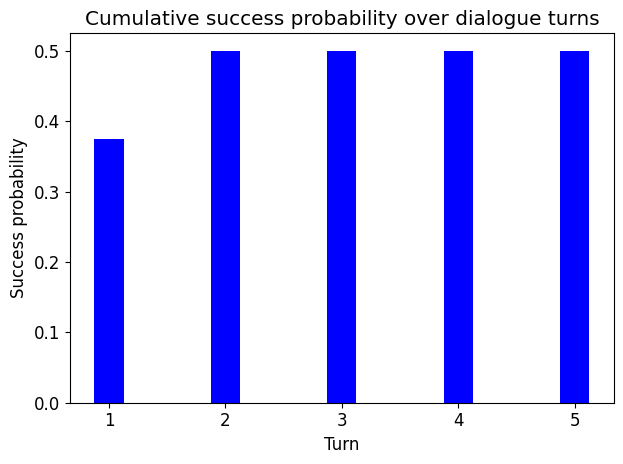

In [9]:
title = "Cumulative success probability over dialogue turns"
width=0.25

ind = np.arange(1, max_turns+1)
plt.bar(ind, cdf_successes_at_turn, width, color='blue')
plt.xlabel("Turn")
plt.ylabel("Success probability")
plt.title(title)
plt.tight_layout()

plt.savefig(Path("./multistep_generation/eval_b/", "cdf_successs_over_turns.svg"), format="svg")
plt.savefig(Path("./multistep_generation/eval_b/", "cdf_successs_over_turns.png"), format="png")
plt.savefig(Path("./multistep_generation/eval_b/", "cdf_successs_over_turns.pdf"), format="pdf")

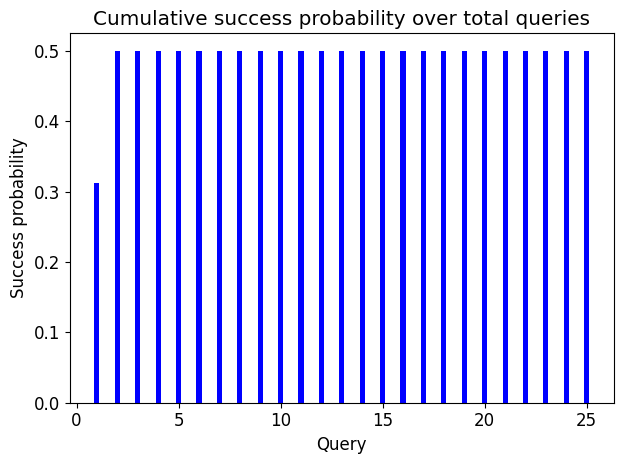

In [10]:
title = "Cumulative success probability over total queries"
width=0.25

ind = np.arange(1, (max_turns*max_queries_per_turn)+1)
plt.bar(ind, cdf_successes_at_total_query, width, color='blue')
plt.xlabel("Query")
plt.ylabel("Success probability")
plt.title(title)
plt.tight_layout()

plt.savefig(Path("./multistep_generation/eval_b/", "cdf_successs_over_total_query.svg"), format="svg")
plt.savefig(Path("./multistep_generation/eval_b/", "cdf_successs_over_total_query.png"), format="png")
plt.savefig(Path("./multistep_generation/eval_b/", "cdf_successs_over_total_query.pdf"), format="pdf")